# Soft Ordering 1D CNN 모델 코드

## 개발 환경 및 라이브러리 버전
- 개발환경: Colab Pro 
- 런타임 유형: GPU
- os: Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
- python: 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
- tensorflow: 2.5.0
- tensorflow.keras: 2.5.0
- tensorflow_addons: 0.13.0
- pandas: 1.1.5
- numpy: 1.19.5
- sklearn: 0.22.2.post1
- kiwipiepy: 0.9.3
- tqdm : 4.62.0

## 구글 드라이브 연결

In [2]:
from google import colab
colab.drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 필요한 패키지 설치하기

In [3]:
!pip install kiwipiepy==0.9.3 # 한국어 형태소 분석 패키지! 리더보드 재현시 사용한 버전 = 0.9.3
!pip install tensorflow-addons 
colab.output.clear()

## 데이터 경로 및 전역 변수 설정
- IS_LOAD_WEIGHTS 변수
    - True: 리더보드 점수 재현을 위해 모델 가중치 불러옵니다.
    - False: 주의!! 모델이 다시 학습합니다. 
- DATA_PATH 변수
    - dacon 에서 제공한 train.csv, test.csv , sample_submission.csv 경로
- CLEANED_PATH
    - train.csv, test.csv 파일 형태소 분석 완료 파일 저장 경로
- SUBMIT_INPUT_PATH 변수
    - 최종 앙상블을 위해 추론확률값(npy 형태) 파일을 저장할 경로
- SUBMIT_OUTPUT_PATH 변수
    - 단독모델 제출파일.csv 저장 경로
- MODELS_PATH 변수
    - 리더보드 점수를 재현을 위한 모델 가중치 저장 또는 저장된 경로
- save_weights_name 변수
    - 새로 모델 학습시 가중치 저장할 파일명
    - IS_LOAD_WEIGHTS = True 일 경우 해당사항 없음

In [4]:
IS_LOAD_WEIGHTS = True

DATA_PATH = "/content/drive/MyDrive/dacon/natural_language_based/root_dir/data/" # 학습및 테스트 데이터 폴더
CLEANED_PATH = "/content/drive/MyDrive/dacon/natural_language_based/root_dir/cleaned/" #학습및 테스트 데이터 형태소 분석 완료 파일 저장 폴더
SUBMIT_INPUT_PATH = "/content/drive/MyDrive/dacon/natural_language_based/root_dir/submit/input/" # 앙상블 하기위해 예측확률 npy 파일 저장 폴더
SUBMIT_OUTPUT_PATH = "/content/drive/MyDrive/dacon/natural_language_based/root_dir/submit/output/" #  단독 모델 추론 csv 파일 저장 경로
MODELS_PATH = "/content/drive/MyDrive/dacon/natural_language_based/root_dir/models/soft_ordering_1d_cnn/" # 모델 가중치 저장 또는 불러오는 폴더

SEED = 42 # 시드값 전역변수
save_weights_name = "soft_ordering_1d_cnn_weights_new_" # 새로 모델 학습후 가중치 저장할 파일명

In [5]:
if IS_LOAD_WEIGHTS:
    save_weights_name = "soft_ordering_1d_cnn_weights_" # 리더보드 재현을 위한 모델 가중치 파일명

save_weights_name

'soft_ordering_1d_cnn_weights_'

## 라이브러리

In [6]:
import os
import sys
import platform
import random
import math
import re
import gc


 
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
 
import sklearn 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer  , TfidfVectorizer
from sklearn.model_selection import StratifiedKFold , KFold
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
 
import tensorflow as tf
import tensorflow_addons as tfa

import kiwipiepy
from kiwipiepy import Kiwi

import warnings
warnings.filterwarnings(action='ignore')
 
print(f"- os: {platform.platform()}")
print(f"- python: {sys.version}")
print(f"- tensorflow: {tf.__version__}")
print(f"- tensorflow.keras: {tf.keras.__version__}")
print(f"- tensorflow_addons: {tfa.__version__}")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- sklearn: {sklearn.__version__}")
print(f"- kiwipiepy: {kiwipiepy.__version__}")

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


- os: Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
- python: 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
- tensorflow: 2.6.0
- tensorflow.keras: 2.6.0
- tensorflow_addons: 0.13.0
- pandas: 1.1.5
- numpy: 1.19.5
- sklearn: 0.22.2.post1
- kiwipiepy: 0.9.3


## 함수 및 클래스 정의

In [7]:
class FeatureGenerator:
    '''데이터 프레임을 받아 dictionary 안에 sparse matrix(tdm or tfidf) 와 numpy(지정한 컬럼들) 배열을 넣어 생성하는 클래스

    Args:
        tdm_list (list): ( tdm 생성할 컬럼명,  max_features ) 의 형태의 tuple을 담은 리스트
        tfidf_list (list): ( tfidf 생성할 컬럼명,  max_features ) 의 형태의 tuple을 담은 리스트
        token_pattern (str): "tdm or tfidf" token_pattern 정규 표현식
        cols_not_sparse (list): 데이터 프레임안에 피쳐로 선택하고자 하는 컬럼명 리스트(예를들어 원핫 인코딩된 컬럼 등...)
 
    Attributes:
        ...
        count_vec (dict): CountVectorizer 객체를 컬럼명 별로 저장
        tfidf_vec (dict): TfidfVectorizer 객체를 컬럼명 별로 저장
        is_fitted (bool): fit 여부
        num_features(int) : 생성 되는 설명변수 개수 

    Examples:
        >>> max_features = 1000
        >>> fg = FeatureGenerator(
                                tdm_list = [
                                        ("TDM생성할컬럼명1",max_features),
                                        ("TDM생성할컬럼명2",max_features),
                                        ...
                                ], 
                                tfidf_list = [
                                        ("tfidf생성할컬럼명1",max_features),
                                        ("tfidf생성할컬럼명2",max_features),
                                        ...
                                ], 
                                cols_not_sparse =  ["학습에사용할컬럼명1","학습에사용할컬럼명2", ...] 
                  )
    
         >>> x_train = fg.fit_transform(train) 
         >>> x_test = fg.transform(test)
    '''

    def __init__(self, 
                 tdm_list = [],
                 tfidf_list = [],
                  token_pattern = '(?u)\\b\\w\\w+\\b',
                  cols_not_sparse = []
                 ):
        
        self.tdm_list = tdm_list
        self.tfidf_list = tfidf_list
        

        self.cols_not_sparse = cols_not_sparse
    
        self.count_vec = {}
        self.tfidf_vec = {}

        self.is_fitted = False
        
        self.token_pattern = token_pattern
        self.num_features = len(cols_not_sparse)

    # private    
    def __make_features(self,x):
        x_dict = {}
        keys = [] 

        if len(self.cols_not_sparse) > 0:
            x_dict["cols_not_sparse"] = x[self.cols_not_sparse].values
            keys.append("cols_not_sparse") 

        for col,_ in self.tdm_list:
            tmp = self.count_vec[col].transform(x[col])
            x_dict[f"{col}_tmp"] = tmp
            keys.append(f"{col}_tmp")

        for col,_ in self.tfidf_list:
            tmp = self.tfidf_vec[col].transform(x[col])
            x_dict[f"{col}_tfidf"] = tmp
            keys.append(f"{col}_tfidf")
        
        x_dict["keys"] = keys # key 순서 보존을 위해 저장
        return x_dict
        
    def fit(self,x ):
        for col,vec_num in self.tdm_list:
            count_vec = CountVectorizer(max_features = vec_num, token_pattern=self.token_pattern)
            count_vec.fit(x[col])
            self.count_vec[col] = count_vec
            self.num_features += len(count_vec.get_feature_names())
        
        for col,vec_num in self.tfidf_list:
            tfidf_vec = TfidfVectorizer(max_features=vec_num , token_pattern=self.token_pattern)
            tfidf_vec.fit(x[col])
            self.tfidf_vec[col] = tfidf_vec
            self.num_features += len(tfidf_vec.get_feature_names())

        self.is_fitted =  True
        
    def fit_transform(self,x):
        self.fit(x)
        x = self.__make_features(x)
        return x

    def transform(self,x):
        if not self.is_fitted:
            print("This FeatureGenerator instance is not fitted yet")
            return
        x = self.__make_features(x)
        return x

print(FeatureGenerator.__doc__)

데이터 프레임을 받아 dictionary 안에 sparse matrix(tdm or tfidf) 와 numpy(지정한 컬럼들) 배열을 넣어 생성하는 클래스

    Args:
        tdm_list (list): ( tdm 생성할 컬럼명,  max_features ) 의 형태의 tuple을 담은 리스트
        tfidf_list (list): ( tfidf 생성할 컬럼명,  max_features ) 의 형태의 tuple을 담은 리스트
        token_pattern (str): "tdm or tfidf" token_pattern 정규 표현식
        cols_not_sparse (list): 데이터 프레임안에 피쳐로 선택하고자 하는 컬럼명 리스트(예를들어 원핫 인코딩된 컬럼 등...)
 
    Attributes:
        ...
        count_vec (dict): CountVectorizer 객체를 컬럼명 별로 저장
        tfidf_vec (dict): TfidfVectorizer 객체를 컬럼명 별로 저장
        is_fitted (bool): fit 여부
        num_features(int) : 생성 되는 설명변수 개수 

    Examples:
        >>> max_features = 1000
        >>> fg = FeatureGenerator(
                                tdm_list = [
                                        ("TDM생성할컬럼명1",max_features),
                                        ("TDM생성할컬럼명2",max_features),
                                        ...
                                ], 
                                t

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    '''sparse 특성들을 배치단위로 압축을 풀고 일반특성들과 concat 하여 배치단위로 생성하는 Generator 클래스

    Args:
        x_set (dict): FeatureGenerator로 생성된 피쳐를 담은 dictionary를 넣으면 됨
        y (ndarray): label 값 넣으면 됨
        len_ (int): 전체 배치 크기 
        batch_size (int): 배치 사이즈 넣으면됨
        is_train (bool): train set 일 경우 True, 그 외는 False 줘야함
        is_test (bool): 모델에 predict 메소드 실행시와 같이 test set 에 대한 추론시 True 줘야함
        is_on_epoch_end_shuffle : 에폭이 끝날 때마다 shuffle 여부(is_train = True 일때만 해당)

    Attributes:
        shape1 (int): 총 피쳐 개수
        indices (ndarray): 배치 색인값

    Examples:
        >>> max_features = 1000
        >>> fg = FeatureGenerator(
                                tdm_list = [
                                        ("TDM생성할컬럼명1",max_features),
                                        ("TDM생성할컬럼명2",max_features),
                                        ...
                                ], 
                                tfidf_list = [
                                        ("tfidf생성할컬럼명1",max_features),
                                        ("tfidf생성할컬럼명2",max_features),
                                        ...
                                ], 
                                cols_not_sparse =  ["학습에사용할컬럼명1","학습에사용할컬럼명2", ...] 
                  )
    
         >>> x_train = fg.fit_transform(train) 
         >>> x_test = fg.transform(test)

         # FeatureGenerator 클래스로 생성한 딕셔너리 데이터를 제너레이터에 넣어야함...
         >>> train_gen = DataGenerator(x_train, get_onehot(y_train),len_ = y_train.shape[0] ,batch_size = 128 )
         >>> test_gen = DataGenerator(x_test,len_ = x_test.shape[0] ,batch_size = 128 ,is_train = False,is_test = True)
    '''
    def __init__(self, x_set, y = None, len_ = 0 ,batch_size = 128 , is_train = True,is_test = False, is_on_epoch_end_shuffle = False):
        self.x_set = x_set
        self.y = y
        self.len_ = len_
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_test = is_test
        self.is_on_epoch_end_shuffle = is_on_epoch_end_shuffle

        self.shape1 = 0

        

        for k in self.x_set["keys"]:
            self.shape1 += self.x_set[k].shape[1]

        
        self.indices = np.arange(self.len_)
        
        if self.is_train:
            np.random.shuffle(self.indices)
 
        
 
    def __len__(self):
        return math.ceil(self.len_ / self.batch_size)
 
    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]

        concat_list = []
        for k in self.x_set["keys"]:
            if k == "cols_not_sparse":
                concat_list.append(self.x_set[k][inds])
            else:
                concat_list.append(self.x_set[k][inds].A)

        batch_x = np.concatenate(concat_list,axis=1)


        if not self.is_test:
            batch_y = self.y[inds]
            return (batch_x,) , batch_y
        else:
            return (batch_x,)
    
 
    def on_epoch_end(self):
        if self.is_on_epoch_end_shuffle:
            np.random.shuffle(self.indices)
        else:
            pass


print(DataGenerator.__doc__)

sparse 특성들을 배치단위로 압축을 풀고 일반특성들과 concat 하여 배치단위로 생성하는 Generator 클래스

    Args:
        x_set (dict): FeatureGenerator로 생성된 피쳐를 담은 dictionary를 넣으면 됨
        y (ndarray): label 값 넣으면 됨
        len_ (int): 전체 배치 크기 
        batch_size (int): 배치 사이즈 넣으면됨
        is_train (bool): train set 일 경우 True, 그 외는 False 줘야함
        is_test (bool): 모델에 predict 메소드 실행시와 같이 test set 에 대한 추론시 True 줘야함
        is_on_epoch_end_shuffle : 에폭이 끝날 때마다 shuffle 여부(is_train = True 일때만 해당)

    Attributes:
        shape1 (int): 총 피쳐 개수
        indices (ndarray): 배치 색인값

    Examples:
        >>> max_features = 1000
        >>> fg = FeatureGenerator(
                                tdm_list = [
                                        ("TDM생성할컬럼명1",max_features),
                                        ("TDM생성할컬럼명2",max_features),
                                        ...
                                ], 
                                tfidf_list = [
                                        ("tfidf생성할컬럼명1",max_f

In [9]:
def reset_seeds(seed = 42):
    '''시드 고정 함수

    Args:
        seed (int): 시드값
    '''
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    print(f"RANDOM SEEDS RESET {seed}")  

print(reset_seeds.__doc__)

시드 고정 함수

    Args:
        seed (int): 시드값
    


In [10]:
def macro_f1(y_true, y_pred):
    '''Macro-F1 함수

    Args:
        y_true (ndarray): 정답값
        y_pred (ndarray): 예측값
    
    Returns:
        float: Macro-F1 Score
    '''
    y_pred = tf.argmax(y_pred,axis=1)
    return f1_score(y_true, y_pred, average='macro')

print(macro_f1.__doc__)

Macro-F1 함수

    Args:
        y_true (ndarray): 정답값
        y_pred (ndarray): 예측값
    
    Returns:
        float: Macro-F1 Score
    


In [11]:
def get_onehot(y):
    '''넘파이 배열 원핫 인코딩 함수
    Args:
        y (ndarray): 원핫인코딩 하고자하는 배열

    Returns:
        ndarray: 원핫 인코딩된 넘파일 배열
    '''
    num = np.unique(y, axis=0)
    num = num.shape[0]
    return np.eye(num)[y]

print(get_onehot.__doc__)

넘파이 배열 원핫 인코딩 함수
    Args:
        y (ndarray): 원핫인코딩 하고자하는 배열

    Returns:
        ndarray: 원핫 인코딩된 넘파일 배열
    


In [12]:
def remove_duplicates(x, seed = 42):
    '''간단한 언더샘플링 함수
    Args:
        x (dataframe): 언더 샘플링하고자하는 판다스 데이터프레임

    Returns:
        dataframe: label이 0인것 중에 동일한 과제명일 경우 첫번째 행만 제외하고 drop 하여 리턴
    '''

    tmp1 = x[x["label"] == 0].reset_index(drop=True)
    tmp2 = x[x["label"] > 0].reset_index(drop=True)
    
    tmp1 = tmp1.drop_duplicates(['과제명'], keep='first').reset_index(drop=True)

    tmp = pd.concat([tmp1,tmp2]).reset_index(drop=True)

    tmp = tmp.sample(frac=1,random_state=seed).reset_index(drop=True)
    return tmp

print(remove_duplicates.__doc__)

간단한 언더샘플링 함수
    Args:
        x (dataframe): 언더 샘플링하고자하는 판다스 데이터프레임

    Returns:
        dataframe: label이 0인것 중에 동일한 과제명일 경우 첫번째 행만 제외하고 drop 하여 리턴
    


In [13]:
def soft_ordering_1d_cnn(x,d_size = 4096, ch_size = 512, k_size = 1,padding='valid', dense_shape1 = 16 ,conv_avg_size = 1 , conv_size = 3):
    '''soft-ordering-1d-cnn 구조를 케라스로 구현한 함수

    Args:
        x (tensor): 텐서
        d_size (int): 첫번째 dense 층의 노드 개수
        ch_size (int): 1D CNN 필터 개수
        k_size (int): 1D CNN 커널크기 
        padding (str): 1D CNN  패딩방식 
        dense_shape1 (int): 첫번째 dense 층에서 나온 노드를 1D CNN 에 넣기 위한 Step 사이즈
        conv_avg_size (int): Conv1D + AveragePooling1D 의 횟수
        conv_size (int): Conv1D의 횟수

    Returns:
        tensor: (batch, new_steps, filters)
    '''
    x = tf.keras.layers.Dense(d_size, activation="relu")(x)
    # x = tf.keras.layers.Dropout(drop_rate)(x)
    x = tf.reshape(x,[ -1,dense_shape1,int(d_size / dense_shape1) ])
    for _ in range(conv_avg_size):
        x = tf.keras.layers.Conv1D(ch_size, k_size, activation="relu", padding=padding)(x)
        x = tf.keras.layers.AveragePooling1D(2)(x)

    for _ in range(conv_size):
        x = tf.keras.layers.Conv1D(ch_size, k_size, activation="relu", padding=padding)(x)
    
    x = tf.keras.layers.MaxPool1D(2)(x)
    
    return x

print(soft_ordering_1d_cnn.__doc__)

soft-ordering-1d-cnn 구조를 케라스로 구현한 함수

    Args:
        x (tensor): 텐서
        d_size (int): 첫번째 dense 층의 노드 개수
        ch_size (int): 1D CNN 필터 개수
        k_size (int): 1D CNN 커널크기 
        padding (str): 1D CNN  패딩방식 
        dense_shape1 (int): 첫번째 dense 층에서 나온 노드를 1D CNN 에 넣기 위한 Step 사이즈
        conv_avg_size (int): Conv1D + AveragePooling1D 의 횟수
        conv_size (int): Conv1D의 횟수

    Returns:
        tensor: (batch, new_steps, filters)
    


In [14]:
def build_model( moa_d_size= 2048 ,moa_ch_size=128 , moa_k_size = 1, moa_dense_shape1 = 16 ,moa_conv_avg_size = 1 , moa_conv_size = 3, moa_padding = 'valid',
                moa_output_type = "avg", final_drop_rate = 0.3,
                tab_shape = 60000,  label_smoothing=0. , 
                 optimizer="adam"):
    '''최종 모델 함수

    Args:
        moa_d_size (int): soft_ordering_1d_cnn 함수의 d_size
        moa_ch_size (int): soft_ordering_1d_cnn 함수의 ch_size
        moa_k_size (int): soft_ordering_1d_cnn 함수의 k_size
        moa_dense_shape1 (int): soft_ordering_1d_cnn 함수의 dense_shape1
        moa_conv_avg_size (int): soft_ordering_1d_cnn 함수의 conv_avg_size
        moa_conv_size (int): soft_ordering_1d_cnn 함수의 conv_size
        moa_padding (str): soft_ordering_1d_cnn 함수의 padding
        moa_output_type (str): avg , max , flat
        final_drop_rate (float): 마지막 drop rate
        tab_shape (int): 설명변수 개수
        label_smoothing (float): CategoricalCrossentropy label_smoothing
        optimizer (str or object): optimizer

    Returns:
        object: 컴파일된 케라스 모델
    '''
    inputs_list = []
    

    inputs_tab = tf.keras.Input(shape=(tab_shape, ))
    inputs_list.append(inputs_tab)
    x = inputs_tab
    x = soft_ordering_1d_cnn(x, d_size = moa_d_size, ch_size = moa_ch_size, k_size = moa_k_size,padding=moa_padding, dense_shape1 = moa_dense_shape1 ,conv_avg_size = moa_conv_avg_size , conv_size = moa_conv_size)
    
    if moa_output_type == "avg":
        x = tf.keras.layers.GlobalAvgPool1D()(x)
    if moa_output_type == "max":
        x = tf.keras.layers.GlobalMaxPool1D()(x)
    if moa_output_type == "flat":
        x = tf.keras.layers.Flatten()(x)

    
    x = tf.keras.layers.Dropout(final_drop_rate)(x)

    outputs = tf.keras.layers.Dense(46,activation="softmax")(x)
    
    
    model = tf.keras.Model(inputs=inputs_list, outputs=outputs)

    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)
    f1 = tfa.metrics.F1Score(num_classes=46,average='macro')
    metrics = ['accuracy',f1]
    model.compile(loss=loss, optimizer=optimizer,metrics=metrics)
    return model

print(build_model.__doc__)

최종 모델 함수

    Args:
        moa_d_size (int): soft_ordering_1d_cnn 함수의 d_size
        moa_ch_size (int): soft_ordering_1d_cnn 함수의 ch_size
        moa_k_size (int): soft_ordering_1d_cnn 함수의 k_size
        moa_dense_shape1 (int): soft_ordering_1d_cnn 함수의 dense_shape1
        moa_conv_avg_size (int): soft_ordering_1d_cnn 함수의 conv_avg_size
        moa_conv_size (int): soft_ordering_1d_cnn 함수의 conv_size
        moa_padding (str): soft_ordering_1d_cnn 함수의 padding
        moa_output_type (str): avg , max , flat
        final_drop_rate (float): 마지막 drop rate
        tab_shape (int): 설명변수 개수
        label_smoothing (float): CategoricalCrossentropy label_smoothing
        optimizer (str or object): optimizer

    Returns:
        object: 컴파일된 케라스 모델
    


In [15]:
reset_seeds(SEED)
tqdm.pandas()

# 키위 패키지 객체 생성 및 키위 모델준비
kiwi = Kiwi()
kiwi.prepare()

RANDOM SEEDS RESET 42


0

## 원본 학습 데이터 불러오기

In [16]:
train = pd.read_csv(f'{DATA_PATH}train.csv')
test = pd.read_csv(f'{DATA_PATH}test.csv')
sample_submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')

## 시간 절약을 위해 미리 형태소 분석 처리한 train_pre.csv 와 test_pre.csv 파일을 불러온다
- CLEANED_PATH 경로에 형태소 분석 완료한 train_pre.csv와 test_pre.csv 파일이 없을 경우 형태소 분석 시작한다. 
- 대략 한시간 정도 소요
- 형태소 분석 처리한 컬럼은 다음과 같다.
    - '사업명' , '내역사업명', '과제명', '요약문_연구목표', '요약문_연구내용', '요약문_기대효과' , '요약문_한글키워드'


In [17]:
is_prefiles = True # train_pre.csv , test_pre.csv 파일 존재 여부 체크 변수
try:
    train = pd.read_csv(f'{CLEANED_PATH}train_pre.csv')
    test= pd.read_csv(f'{CLEANED_PATH}test_pre.csv')
except FileNotFoundError as e:
    is_prefiles = False
    print(e)

is_prefiles

True

In [18]:
# 형태소 분석을 위한 함수 정의
def extract_nvs(txt):
    tokens = [
          f"{token}/{pos}" 
          for token , pos ,_ ,_ in txt[0][0] 
            if pos.startswith('N') or pos.startswith('V') or pos == "SL"
    ]
    return " ".join(tokens)

- 아래 코드 총 소요시간
    
    - 100%|██████████| 7/7 [1:02:26<00:00, 535.27s/it] 
    - 총 60분 정도 소요(Colab Pro 런타임환경 GPU 기준)
    - 기존 소요시간 185분정도 였으나 내장함수(map,list)를 이용하여 소요시간 줄임


In [19]:
if not is_prefiles: # train_pre.csv , test_pre.csv 파일 없을 경우 형태소 분석 진행
    train = train.fillna("nan") 
    test = test.fillna("nan")

    cols = ['사업명' , '내역사업명', '과제명', '요약문_연구목표', '요약문_연구내용', '요약문_기대효과' , '요약문_한글키워드']
    reg_txt = r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]" # 한글과 영문자가 아닐경우 공백으로 변경하기 위한 정규식
    for col in tqdm(cols): # 컬럼별로 처리
        result = kiwi.analyze( train[col].astype(str).str.replace(reg_txt," ") )
        result = map(extract_nvs , result)
        train[f"{col}_pre"] = list(result)

        result = kiwi.analyze( test[col].astype(str).str.replace(reg_txt," ") )
        result = map(extract_nvs , result)
        test[f"{col}_pre"] = list(result)

    #저장
    train.to_csv(f'{CLEANED_PATH}train_pre.csv', index=False)
    test.to_csv(f'{CLEANED_PATH}test_pre.csv', index=False)

    #다시 불러오기
    train = pd.read_csv(f'{CLEANED_PATH}train_pre.csv')
    test = pd.read_csv(f'{CLEANED_PATH}test_pre.csv')

## 텍스트컬럼에 대한 간단한 전처리 및 피쳐 추가

- 형태소 분석된 컬럼에서 품사 태그 제거하기

In [20]:
cols = ['사업명_pre' , '내역사업명_pre', '과제명_pre', '요약문_연구목표_pre', 
        '요약문_연구내용_pre', '요약문_기대효과_pre' , '요약문_한글키워드_pre']

for col in cols:
    train[col] = train[col].str.replace(r"/[A-Z]+","")
    test[col] = test[col].str.replace(r"/[A-Z]+","")

- 요약문_영문키워드 컬럼에서 숫자 제거

In [21]:
train["요약문_영문키워드"] = train["요약문_영문키워드"].str.replace(r"[0-9]+","")
test["요약문_영문키워드"] = test["요약문_영문키워드"].str.replace(r"[0-9]+","")

- "제출년도","사업_부처명","계속과제여부" 컬럼에 대해 원핫 인코딩
    

In [22]:
# 다음의 컬럼 원핫 인코딩 
cols = ["제출년도","사업_부처명","계속과제여부"]
oh_enc = OneHotEncoder(handle_unknown="ignore")
tmp = pd.DataFrame(
                oh_enc.fit_transform(train[cols]).toarray(), 
                columns=oh_enc.get_feature_names(cols)
             )

train = pd.concat([train,tmp],axis=1)

tmp = pd.DataFrame(
                oh_enc.transform(test[cols]).toarray(), 
                columns=oh_enc.get_feature_names(cols)
             )
test = pd.concat([test,tmp],axis=1)

del tmp
gc.collect()

36

- 원핫 인코딩된 컬럼명 피쳐로 사용하기 위해 cols_not_sparse 리스트에 저장

In [23]:
cols_not_sparse = oh_enc.get_feature_names(cols).tolist()
cols_not_sparse

['제출년도_2016',
 '제출년도_2017',
 '제출년도_2018',
 '제출년도_2019',
 '사업_부처명_경찰청',
 '사업_부처명_과학기술정보통신부',
 '사업_부처명_교육부',
 '사업_부처명_국민안전처',
 '사업_부처명_국토교통부',
 '사업_부처명_기상청',
 '사업_부처명_기획재정부',
 '사업_부처명_농림축산식품부',
 '사업_부처명_농촌진흥청',
 '사업_부처명_다부처',
 '사업_부처명_문화재청',
 '사업_부처명_문화체육관광부',
 '사업_부처명_미래창조과학부',
 '사업_부처명_범부처 사업',
 '사업_부처명_보건복지부',
 '사업_부처명_산림청',
 '사업_부처명_산업통상자원부',
 '사업_부처명_소방청',
 '사업_부처명_식품의약품안전처',
 '사업_부처명_원자력안전위원회',
 '사업_부처명_중소기업청',
 '사업_부처명_중소벤처기업부',
 '사업_부처명_특허청',
 '사업_부처명_해양경찰청',
 '사업_부처명_해양수산부',
 '사업_부처명_행정안전부',
 '사업_부처명_행정자치부',
 '사업_부처명_환경부',
 '계속과제여부_계속',
 '계속과제여부_신규']

- 임시로 text 컬럼들의 결측치 nan 문자로 대체

In [24]:
train = train.fillna("nan")
test = test.fillna("nan")

- 다음의 URL 의 기후기술 분류 체계에서 기술 정의와 기술 키워드 부분을 가져와 txt 파일로 생성함
- https://www.ctis.re.kr/ko/techClass/classification.do?key=1141
- 중복을 제외하고 29가지의 기술정의와 키워드가 있음

- txt 파일 불러오고 리스트로 변환

In [25]:
# 아래는 기술정의와  키워드 병합
# f = open(f'{CLEANED_PATH}web_기후기술분류체계.txt','r')
# txt = f.read()
# f.close()

# txt = txt.split("\n\n")
# txt = [ t.replace("\n"," ") for t in txt ]

# 아래는 키워드만 추출
f = open(f'{CLEANED_PATH}web_기후기술분류체계.txt','r')
txt = f.read()
f.close()

txt = txt.split("\n")
txt = [ t.replace("\n"," ") for t in txt ]
txt = [ t for t in txt if t != "" ]
txt = [ t for i,t in enumerate(txt) if i % 2  > 0 ]

txt

['소듐냉각고속로, 초고온가스로, 핵융합로, 납냉각고속로, 가속기 구동 미임계로, 차세대경수로, 사용 후 핵연료, 순환핵연료주기, 고준위(방사성) 폐기물, 원전 해체(폐로), 파이로 공정, 금속연료, 장수명핵종 변환, 초우란원소, 최종처분, 중간저장',
 '블랑켓, 삼중수소 연료주기, 저방사화 재료, 동력변환',
 '고효율발전, 초초임계발전, 가스복합발전, 유동층발전, 가스화연료전지기술, 바이오매스혼소, 순산소연소발전, 고효율가스터빈, 청정석탄기술',
 '수력, 수차, 발전기, 소수력, 출력',
 '태양전지, 모듈, 인버터, 실리콘 태양전지, 비실리콘 태양전지, 고효율',
 '태양열집열, 집광형 태양열, 태양광열 복합, 태양열저장, 태양열 온수, 태양열 난방, 태양열냉방, 태양열 담수, 태양열 산업공정열, 태양열주택, 태양열 지역난방, 집광형 태양열 발전, 태양열 연료',
 '지열, 지열에너지, 지열발전, 지열직접이용, 심부지열, 지열 냉난방, 지열원 열펌프, 인공 지열저류층 생성기술, 열수자원, 지하 열에너지 저장',
 '풍력터빈, 풍력발전단지, 육상풍력발전, 해상풍력발전, 부유식풍력발전, 바람자원평가, 바람자원측정, 블레이드, 타워, 기어박스, 발전기, 나셀, 드라이브트레인, 인증, 설계평가, 출력곡선, 출력효율, 실증시험, 실증단지, 저 풍속 형 풍력터빈, 대형풍력터빈, 소형풍력터빈, 수평축 풍력터빈, 수직축풍력터빈, 제어기, 해저케이블, 육상변전소, 해상변전소, 유지보수, 균등화발전단가, 경제성평가, 사업타당성검토',
 '조류발전, 조력발전, 파력발전, 해수온도차발전, 해수냉난방, 해수염도차발전',
 '바이오매스, 바이오에너지, 바이오연료, 바이오알코올, 바이오에탄올, 바이오부탄올, 바이오가스, 바이오메탄, 바이오수소, 바이오리파이너리, 바이오디젤, 바이오고탄소연료, 바이오고형연료, 우드칩, 우드팰릿, 전처리, 당화, 리그닌, 리그노셀룰로오스',
 '폐기물에너지, 폐기물에너지화기술, 폐기물 연료화기술, 고형연료화 기술, 열분해 가스화, 열분해 유화',


- web_기후기술분류체계.txt 파일의 NNG 와 NNP 태그 만을 추출하여 형태소분석 진행

In [26]:
def extract_n(txt):
    tokens = []
    pos_list = ["NNG","NNP"]
    for token , pos ,_ ,_ in txt[0][0]:
        if pos in pos_list:
            tokens.append(token)
    return " ".join(tokens)

result = kiwi.analyze(txt)
map_ = map(extract_n , result)

txt_list = list(map_)
len(txt_list)

29

- web_기후기술분류체계.txt 파일의 데이터를 tfidf 분석

In [27]:
tv = TfidfVectorizer(max_features=None)
txt_vec = tv.fit_transform(txt_list)

- web_기후기술분류체계.txt 에 포함된 단어만을 이용
- web_기후기술분류체계.txt 의 각 분류의 tfidf값과 cols 리스트에 컬럼의 데이터 샘플들의 tfidf값의 코사인 유사도를 피쳐로 추가

In [28]:
cols = [
        # '사업명_pre' ,
        '내역사업명_pre', 
        '과제명_pre', 
        # '요약문_연구목표_pre', 
        # '요약문_연구내용_pre', 
        # '요약문_기대효과_pre' ,
        '요약문_한글키워드_pre',
        ]
for col in tqdm(cols):
    # web_기후기술분류체계.txt 에 포함된 단어만을 이용하여 학습데이터의 tfidf 분석
    tvt = TfidfVectorizer(vocabulary=tv.get_feature_names()) 
    text_tvt = tvt.fit_transform(train[col])
    tmp2 = text_tvt.A

    #web_기후기술분류체계.txt의 tfidf 와 학습데이터의 tfidf  간에 코사인 유사도를 구함 
    for i,t in enumerate(txt_vec):
        similarity_simple_pair = cosine_similarity(t.A, tmp2) 
        train[f"{col}_cosine_{i}"] = similarity_simple_pair.reshape(-1)

        cols_not_sparse.append(f"{col}_cosine_{i}") # 학습 과정에서 피쳐로 사용하기 위해 컬럼명을 cols_not_sparse 리스트에 저장

    # 테스트 데이터 동일하게 진행
    text_tvt = tvt.transform(test[col])
    tmp2 = text_tvt.A

    for i,t in enumerate(txt_vec):
        similarity_simple_pair = cosine_similarity(t.A, tmp2)
        test[f"{col}_cosine_{i}"] = similarity_simple_pair.reshape(-1)


del similarity_simple_pair
del tmp2
del text_tvt
gc.collect()

100%|██████████| 3/3 [00:59<00:00, 19.98s/it]


26

- web_기후기술분류체계.txt 에 포함된 단어만을 이용
- cols 리스트에 컬럼의 데이터 샘플들의 tdm 을 생성하여 web_기후기술분류체계.txt 의 각 분류의 tfidf값 곱하고 합한 값을 피쳐로 추가
- 내적을 이용하여 계산

In [29]:
cols = [
        # '사업명_pre' ,
        '내역사업명_pre', 
        '과제명_pre', 
        # '요약문_연구목표_pre', 
        # '요약문_연구내용_pre', 
        # '요약문_기대효과_pre' ,
        '요약문_한글키워드_pre',
        ]
for col in cols:
    # web_기후기술분류체계.txt 에 포함된 단어만을 이용하여 학습데이터의 TDM 생성
    cvt = CountVectorizer(vocabulary=tv.get_feature_names())
    text_cvt = cvt.fit_transform(train[col])

    
    tmp2 = txt_vec.A.T # 내적 계산을 위해 web_기후기술분류체계.txt의 tfidf를 transpose
    tmp1 = text_cvt.A
    tmp = pd.DataFrame(tmp1.dot(tmp2)).add_prefix(f"{col}_") # 내적 계산 후 데이터프레임 생성
    train = pd.concat([train,tmp],axis=1)
    cols_not_sparse.extend(tmp.columns.tolist()) # 학습 과정에서 피쳐로 사용하기 위해 컬럼명을 cols_not_sparse 리스트에 저장

    # 테스트 데이터 동일하게 진행
    text_cvt = cvt.transform(test[col])
    tmp2 = txt_vec.A.T
    tmp1 = text_cvt.A
    tmp = pd.DataFrame(tmp1.dot(tmp2)).add_prefix(f"{col}_")
    test = pd.concat([test,tmp],axis=1)


del tmp2
del tmp1
del tmp
del text_cvt
gc.collect()

0

In [30]:
# web_기후기술분류체계.txt의 단어별 tfidf의 sum 값을 딕셔너리로 생성
txt_dict = dict( zip( tv.get_feature_names(), txt_vec.A.sum(axis=0) ) )
len(txt_dict) 

451

- web_기후기술분류체계.txt 에 포함된 단어만을 이용
- cols 리스트에 컬럼의 데이터 샘플들의 tdm 을 생성하여 web_기후기술분류체계.txt 의 각 단어의 tfidf값 곱하여 피쳐로 추가

In [31]:
cols = [
        # '사업명_pre' ,
        '내역사업명_pre', 
        '과제명_pre', 
        # '요약문_연구목표_pre', 
        # '요약문_연구내용_pre', 
        # '요약문_기대효과_pre' ,
        '요약문_한글키워드_pre',
        ]
for col in cols:
    # web_기후기술분류체계.txt 에 포함된 단어만을 이용하여 학습데이터의 TDM 생성
    cvt = CountVectorizer(vocabulary=txt_dict.keys())
    text1_cvt = cvt.fit_transform(train[col])
    
    tmp = pd.DataFrame(text1_cvt.A,columns=cvt.get_feature_names()) # TDM 데이터 프레임 생성
    tmp = tmp.mul(txt_dict.values(),axis=1).add_prefix(f"{col}_tfidf_score_") # TDM 행렬에 web_기후기술분류체계.txt의 단어별 tfidf의 sum 값 벡터를 곱하여 피쳐생성
    train = pd.concat([train,tmp],axis=1)
    cols_not_sparse.extend(tmp.columns.tolist()) # 학습 과정에서 피쳐로 사용하기 위해 컬럼명을 cols_not_sparse 리스트에 저장

    # 테스트 데이터 동일하게 진행
    text1_cvt = cvt.transform(test[col])
    tmp = pd.DataFrame(text1_cvt.A,columns=cvt.get_feature_names())
    tmp = tmp.mul(txt_dict.values(),axis=1).add_prefix(f"{col}_tfidf_score_")
    test = pd.concat([test,tmp],axis=1)


del tmp
del text1_cvt
gc.collect()

13

In [32]:
len(cols_not_sparse) # 별도로 생성한 피쳐 개수

1561

- 새로 추가한 피쳐에 대한 스케일링

In [33]:
mins = train[cols_not_sparse].min()
sizes = train[cols_not_sparse].max() - mins


train[sizes[(sizes > 0)].index] = ( train[sizes[(sizes > 0)].index] -  mins[(sizes > 0)] ) / sizes[(sizes > 0)]
test[sizes[(sizes > 0)].index] = ( test[sizes[(sizes > 0)].index] -  mins[(sizes > 0)] ) / sizes[(sizes > 0)]

## 데이터 학습 

- 정답 값 

In [34]:
y_train = train.label.values # 정답값

- 모델 구조 확인

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60000)]           0         
_________________________________________________________________
dense (Dense)                (None, 2048)              122882048 
_________________________________________________________________
tf.reshape (TFOpLambda)      (None, 16, 128)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 16, 128)           16512     
_________________________________________________________________
average_pooling1d (AveragePo (None, 8, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 128)            16512     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 128)            16512 

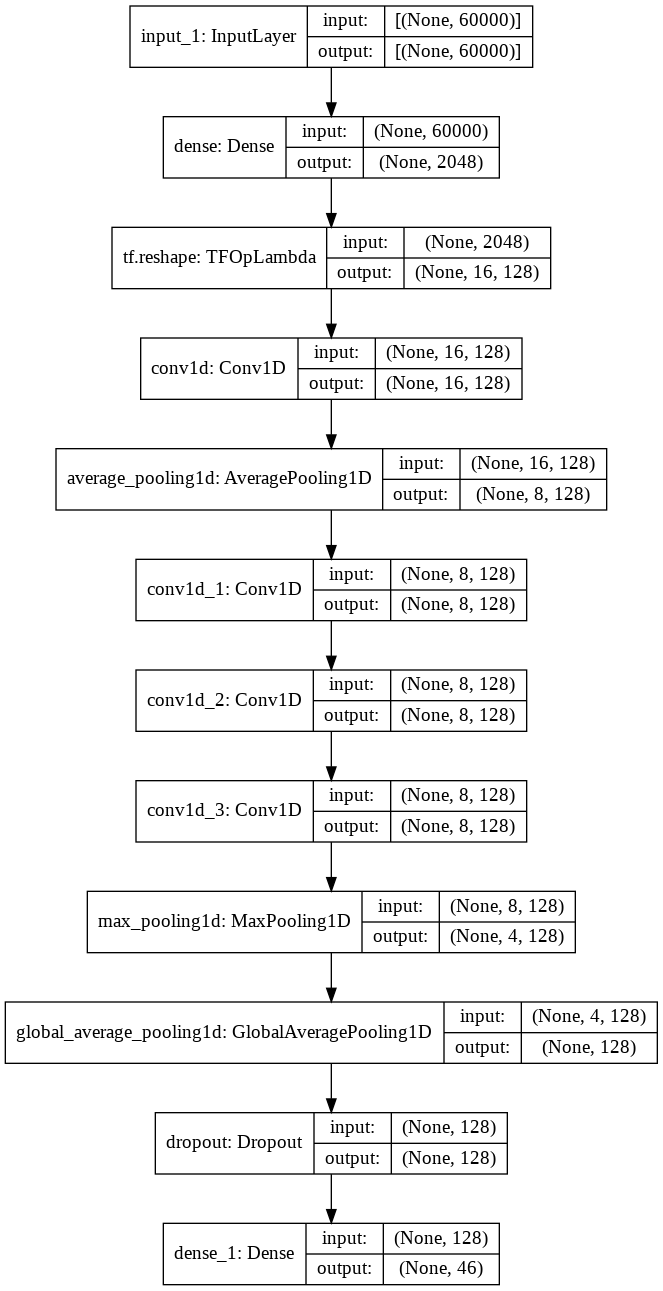

In [35]:
model = build_model()
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

- 학습 시작
    - 리더보드 재현을 위해 모델 가중치를 불러올 경우 모델 학습만 진행 하지 않고 tfidf 피쳐생성 위한 fit 과  모델 하이퍼파라미터 저장만 실행 됩니다.
    - 모델을 학습할 경우 Colab Pro GPU & 배치사이즈 64 기준으로 에폭당 60~70초 가량 걸립니다. 
    - CV 5 fold 로 학습을 진행합니다.(5개의 모델이 생성됩니다.)
    - 검증셋에 대하여 Transform 만 진행합니다. 이는 검증셋 에 대해서도 Data Leakage 요소를 제거하여 오버핏을 방지하고 일반화 성능을 높이기 위함 입니다. fit 을 총 5번 하기 때문에 추론 과정에서도 test 셋에 대하여 동일하게 5번 Transform 해서 TTA 효과도 기대합니다.

In [36]:
is_holdout = False # True 지정시 holdout 으로 만 학습합니다.. 나의 가설이 괜찮은지 holdout 으로 체크해봅니다.
model_idx = 0 # 모델 인덱스
n_splits = 5 # cv 개수
 
fg_list = []  # tdm or tfidf 등과 같은 테이블형 피쳐를 생성하는 클래스 객체를 저장하기 위한 리스트
hp_dict_list = [] # bulid_model 하이퍼파라미터를 저장하기 위한 리스트

batch_size = 64 # 배치 사이즈

scores = []

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
for tri, vai in cv.split(train,y_train):
    reset_seeds(SEED)
    # f1 score 최적의 값을 내놓은 모델 가중치 복구
    es = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=5,mode="max",restore_best_weights=True)
 
    xt = train.iloc[tri].reset_index(drop=True) # 학습셋
    xv = train.iloc[vai].reset_index(drop=True) # 검증셋
    
    yt = y_train[tri] # 학습 정답값
    yv = y_train[vai] # 검증 정답값
 
    # 간단한 언더샘플링 시도시 다음의 주석을 풀면 됨
    # xt = remove_duplicates(xt) 
    # yt = xt.label.values
 
    max_features = 10000 # 각 컬럼별 tfidf or tdm 에 대한 max_features 
    fg = FeatureGenerator(tdm_list = [], # TDM 도 넣어봐서 해보자 (tfidf 와 같은 방식 튜플로 해서 넣으면 됨)
                 tfidf_list = [
                               ("사업명_pre",max_features),  # 주석처리 해서 돌려보자
                               ("내역사업명_pre",max_features), # 주석처리 해서 돌려보자
                               ("과제명_pre",max_features), # 주석처리 해서 돌려보자
                               ("요약문_연구목표_pre",max_features), # 주석처리 해서 돌려보자
                               ("요약문_연구내용_pre",max_features), # 주석처리 해서 돌려보자
                               ("요약문_기대효과_pre",max_features), # 주석처리 해서 돌려보자
                               ("요약문_한글키워드_pre",max_features), # 주석처리 해서 돌려보자
                                ("요약문_영문키워드",max_features), # 주석처리 해서 돌려보자
                               ],
                  token_pattern = '(?u)\\b\\w\\w+\\b', 
                  cols_not_sparse =  cols_not_sparse # 컬럼의 원핫 인코딩된 컬럼과 추가로 생성한 피쳐 컬럼 .. (제출년도","사업_부처명","계속과제여부", ....)
                  )
    
    fg.fit(xt) # 학습 셋만 fit
    hp_dict = {
        "moa_d_size":2048 ,
        "moa_ch_size":128 , 
        "moa_k_size":1,
        "moa_dense_shape1":16 ,
        "moa_conv_avg_size" : 1 , 
        "moa_conv_size" : 3, 
        "moa_padding" : 'valid', # valid , same
        "moa_output_type" : "flat", # avg , max , flat
        "final_drop_rate" : 0.3,
        "tab_shape" : fg.num_features, # 테이블형식의 피쳐 개수
        "label_smoothing" : 0.25,
    }
    hp_dict_list.append(hp_dict) # 테스트셋 추론시 필요하므로 하이퍼파라미터 저장
    fg_list.append(fg) # 테스트셋 추론시 필요하므로 FeatureGenerator 객체 저장

    if not IS_LOAD_WEIGHTS: # 재현을 위해 가중치 불러올경우 실행 안함
        xt = fg.transform(xt)  # 학습셋 테이블형 피쳐 생성
        xv = fg.transform(xv) # 검증셋 테이블형 피쳐 생성 
         
        # tfidf 피쳐생성시 최대한 많은 단어를 사용하여 학습하고 OOM 방지를 하고 배치 단위로 sparse 데이터를 numpy 로 변환하기위해 제너레이터 클래스 구현하여 학습
        # 데이터 제너레이터에 FeatureGenerator 생성된 딕셔너리 데이터 넣기
        train_gen = DataGenerator(xt,get_onehot(yt),len_ = yt.shape[0] ,batch_size = batch_size ) # 학습셋
        valid_gen = DataGenerator(xv,get_onehot(yv),len_ = yv.shape[0] ,batch_size = batch_size ,is_train = False) # 검증셋은 섞을 필요 없으므로 is_train = False
        
        print(f"특성 개수:{train_gen.shape1}")

        model = build_model(**hp_dict)
        history = model.fit(train_gen , epochs=50, batch_size= batch_size,callbacks=[es], validation_data=valid_gen
                            )

        # 모델 가중치 저장
        model.save_weights(f"{MODELS_PATH}{save_weights_name}{model_idx}.h5")
        scores.append(max(history.history["val_f1_score"]))

        del model
        del train_gen
        del valid_gen

    del xt
    del xv
    del yt
    del yv
    gc.collect()
    tf.keras.backend.clear_session()


    if is_holdout:
        break 
    
    model_idx +=1

RANDOM SEEDS RESET 42
RANDOM SEEDS RESET 42
RANDOM SEEDS RESET 42
RANDOM SEEDS RESET 42
RANDOM SEEDS RESET 42


In [37]:
scores

[]

- 테스트셋 추론 및 검증점수 확인


In [38]:
preds = [] # 각 폴드별 테스트셋에 대하여 예측 확률을 담기 위한 리스트
model_idx = 0 
scores_valid = [] # 검증 점수 리스트
scores_report_list = [] # 클래스 별 평가지표를 담기 위한 리스트

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
for tri, vai in cv.split(train,y_train):
    
    model = build_model(**hp_dict_list[model_idx]) # 위에서 저장한 하이퍼 파라미터 세팅
    model.load_weights(f"{MODELS_PATH}{save_weights_name}{model_idx}.h5") # 저장된 모델 가중치 load


    xv = train.iloc[vai].reset_index(drop=True) # 검증셋
    yv = y_train[vai] # 검증 정답값

    # 테이블형 피쳐 생성
    xv = fg_list[model_idx].transform(xv)  # 검증
    xte = fg_list[model_idx].transform(test)  # 테스트
    
    # 제너레이터 객체 생성 
    valid_gen = DataGenerator(xv,len_ = yv.shape[0] ,batch_size = batch_size ,is_train = False,is_test=True) # 검증
    test_gen = DataGenerator(xte,len_ = test.shape[0] ,batch_size = batch_size ,is_train = False,is_test=True)  # 테스트
    
    pred_valid = model.predict(valid_gen) # 검증셋 예측
    pred_test = model.predict(test_gen) # 테스트셋 예측
    
    preds.append(pred_test) # 테스트셋 예측확률 저장
    
    

    score = macro_f1(yv,pred_valid) # 검증셋 f1 score
    scores_valid.append(score)
    print( f"- {model_idx+1} fold score : {score}" )
    
    # 검증셋에 대하여 클래스별 평가지표 
    scores_report = classification_report(yv,np.argmax(pred_valid,axis=1),output_dict =True)
    scores_report_list.append(scores_report)

    del model
    del valid_gen
    del test_gen
    del xv
    del yv
    del xte
    gc.collect()
    tf.keras.backend.clear_session()
 
    if is_holdout:
        break 

    model_idx +=1
 
print("-"*20)
 
print( f"- score mean : {np.mean(scores_valid)}" )

- 1 fold score : 0.787227701080918
- 2 fold score : 0.7909190887241712
- 3 fold score : 0.7920910220394863
- 4 fold score : 0.7833582278258887
- 5 fold score : 0.7992497248560141
--------------------
- score mean : 0.7905691529052956


- 클래스별 f1 score 확인해보기

In [39]:
f1_scores_list = []
for scores in scores_report_list:
    f1_scores = []
    for label in range(46):
        f1_scores.append( scores[f"{label}"]["f1-score"] )
    
    f1_scores_list.append(f1_scores)
    print( np.mean(f1_scores) )

print("="*20)
class_scores = np.mean(f1_scores_list,axis=0)
for i,s in enumerate(class_scores):
    print(f"{i} class f1-score: {s}")

0.787227701080918
0.7909190887241712
0.7920910220394863
0.7833582278258887
0.7992497248560141
0 class f1-score: 0.9695623092044083
1 class f1-score: 0.9193798907650592
2 class f1-score: 0.922926733876257
3 class f1-score: 0.7780151656622245
4 class f1-score: 0.9673043478260869
5 class f1-score: 0.8947183694801512
6 class f1-score: 0.8476190476190475
7 class f1-score: 0.8381204067250578
8 class f1-score: 0.943923503124285
9 class f1-score: 0.8224538362792535
10 class f1-score: 0.7679458370940808
11 class f1-score: 0.6695421663946253
12 class f1-score: 0.7017278168757493
13 class f1-score: 0.8034296485601985
14 class f1-score: 0.8702421869842194
15 class f1-score: 0.8424873737373737
16 class f1-score: 0.7575893364716895
17 class f1-score: 0.526647094397713
18 class f1-score: 0.7706912696313645
19 class f1-score: 0.8055606768517697
20 class f1-score: 0.5351199200009524
21 class f1-score: 0.8784491897840576
22 class f1-score: 0.7600784200106234
23 class f1-score: 0.7866080982432804
24 clas

- 다른 모델과 앙상블 하기위해 SUBMIT_INPUT_PATH 경로에 npy 파일로 저장 

In [40]:
np.save(f'{SUBMIT_INPUT_PATH}{save_weights_name}', preds)
print("끝")

끝


## 개인모델 점수 확인할 경우 is_to_csv 변수 값을 True 변경 후  실행

In [41]:
is_to_csv = False

In [42]:
if is_to_csv:
    pred = np.mean(preds,axis=0)
    print(len(preds))
    pred = tf.argmax(pred,axis=1)
    pred

In [43]:
if is_to_csv:
    sample_submission["label"] = pred
    sample_submission

In [44]:
if is_to_csv:
    sample_submission.to_csv(f'{SUBMIT_OUTPUT_PATH}{save_weights_name}.csv', index=False)